# Modelling Customer Satisfaction

##### The aim of this project is to model customer satisfaction for a logistics and delivery startup. The dataset we will be working with was collected via a customer satisfaction survey, and provided by the startup. Our goal is to create a model that predicts customer satisfaction given responses to the other questions in the survey. Furthermore, our aim is to create an easily interpretable model, so that the startup can learn where it needs to improve its service to improve customer satisfaction. 

Useful python libraries and functions to use later on

In [1]:
import random
seed = random.randint(1000,9999)
print(seed)

7980


In [3]:
seed = 7980

In [10]:
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    make_scorer, precision_score, recall_score, roc_auc_score, f1_score, accuracy_score, classification_report,
    roc_curve, auc, precision_recall_curve, confusion_matrix)
from scipy.stats.distributions import loguniform
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from lazypredict.Supervised import LazyClassifier

from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline  # combining classifier steps
from sklearn.preprocessing import StandardScaler # scaling features

import numpy as np
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score, make_scorer
from hyperopt import space_eval



In [5]:
#ROC curve drawing by using the helper function
def plot_roc_curve(roc):
    """
    Plots the ROC curve from a DataFrame.
    
    Parameters:
    - roc: DataFrame containing 'false positive rate', 'true positive rate', and 'threshold' columns.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(roc['false positive rate'], roc['true positive rate'], label='ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')  # adding a 45-degree dashed line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

In [6]:
def pretty_confusion_matrix(confmat, labels, title, labeling=False, highlight_indexes=[]):
    '''
    Plots the confusion matrix, given relevant data.
    '''
    labels_list = [["TN", "FP"], ["FN", "TP"]]
    
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            if labeling:
                label = str(confmat[i, j])+" ("+labels_list[i][j]+")"
            else:
                label = confmat[i, j]
            
            
            if [i,j] in highlight_indexes:
                ax.text(x=j, y=i, s=label, va='center', ha='center',
                        weight = "bold", fontsize=18, color='#32618b')
            else:
                ax.text(x=j, y=i, s=label, va='center', ha='center')
       
    # change the labels
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ax.set_xticklabels(['']+[labels[0], labels[1]])
        ax.set_yticklabels(['']+[labels[0], labels[1]])

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    ax.xaxis.set_label_position('top')
    plt.suptitle(title)
    plt.tight_layout()
    
    plt.show()

In [7]:
from matplotlib.patches import Patch

def plot_coefs(all_coeffs, order, title):
    '''
    Function for plotting a barplot of the coefficients of the fitted model.
    Will be used in logistic regression model.
    '''
    # setting colors for positive and negative coefficients.
    colors = ['red' if value > 0 else 'blue' for value in all_coeffs]
    
    plt.bar(range(len(all_coeffs)),all_coeffs, align='center', color=colors)
    plt.xticks(range(len(order)), order, size='small',rotation = 70)
    plt.tight_layout
    # Create custom legend entries
    legend_handles = [
        Patch(color='red', label='Positive'),
        Patch(color='blue', label='Negative')
    ]
    
    plt.legend(handles=legend_handles)
    
    # Set labels and title
    plt.xlabel('Features')
    plt.ylabel('Coefficient Value')
    plt.title(title)

#### **EDA**

Description of data

Y = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers\
X1 = my order was delivered on time\
X2 = contents of my order was as I expected\
X3 = I ordered everything I wanted to order\
X4 = I paid a good price for my order\
X5 = I am satisfied with my courier\
X6 = the app makes ordering easy for me

Attributes X1 to X6 indicate the responses for each question and have values from 1 to 5 where the smaller number indicates less and the higher number indicates more towards the answer.

Thus, in this project, we are dealing with a classification problem. Our target variable is Y and our feature variables are X1 to X6.


In [5]:
import pandas as pd
df = pd.read_csv("ACME-HappinessSurvey2020.csv")
df.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


##### Comments

Above we see that the dataset consists of 126 data points. Thus, we are working with a relatively small dataset. Fortunately, there appear to be no null values in the dataset.

In [9]:
df.describe()

,Y,X1,X2,X3,X4,X5,X6
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,0.547619,4.333333,2.531746,3.309524,3.746032,3.650794,4.253968
std,0.499714,0.800000,1.114892,1.023440,0.875776,1.147641,0.809311
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,4.000000,2.000000,3.000000,3.000000,3.000000,4.000000
50%,1.000000,5.000000,3.000000,3.000000,4.000000,4.000000,4.000000
75%,1.000000,5.000000,3.000000,4.000000,4.000000,4.000000,5.000000
max,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


##### Comments

Above we see that the mean of the target variable is approximately 0.548. Thus, it appears that there is a fairly even split between Y = 0 and Y = 1 cases. Therefore, the dataset does not appear to be imbalanced. The distribution of the features (X1-X6) is less clear from the table above. Below, we will plot the distributions.

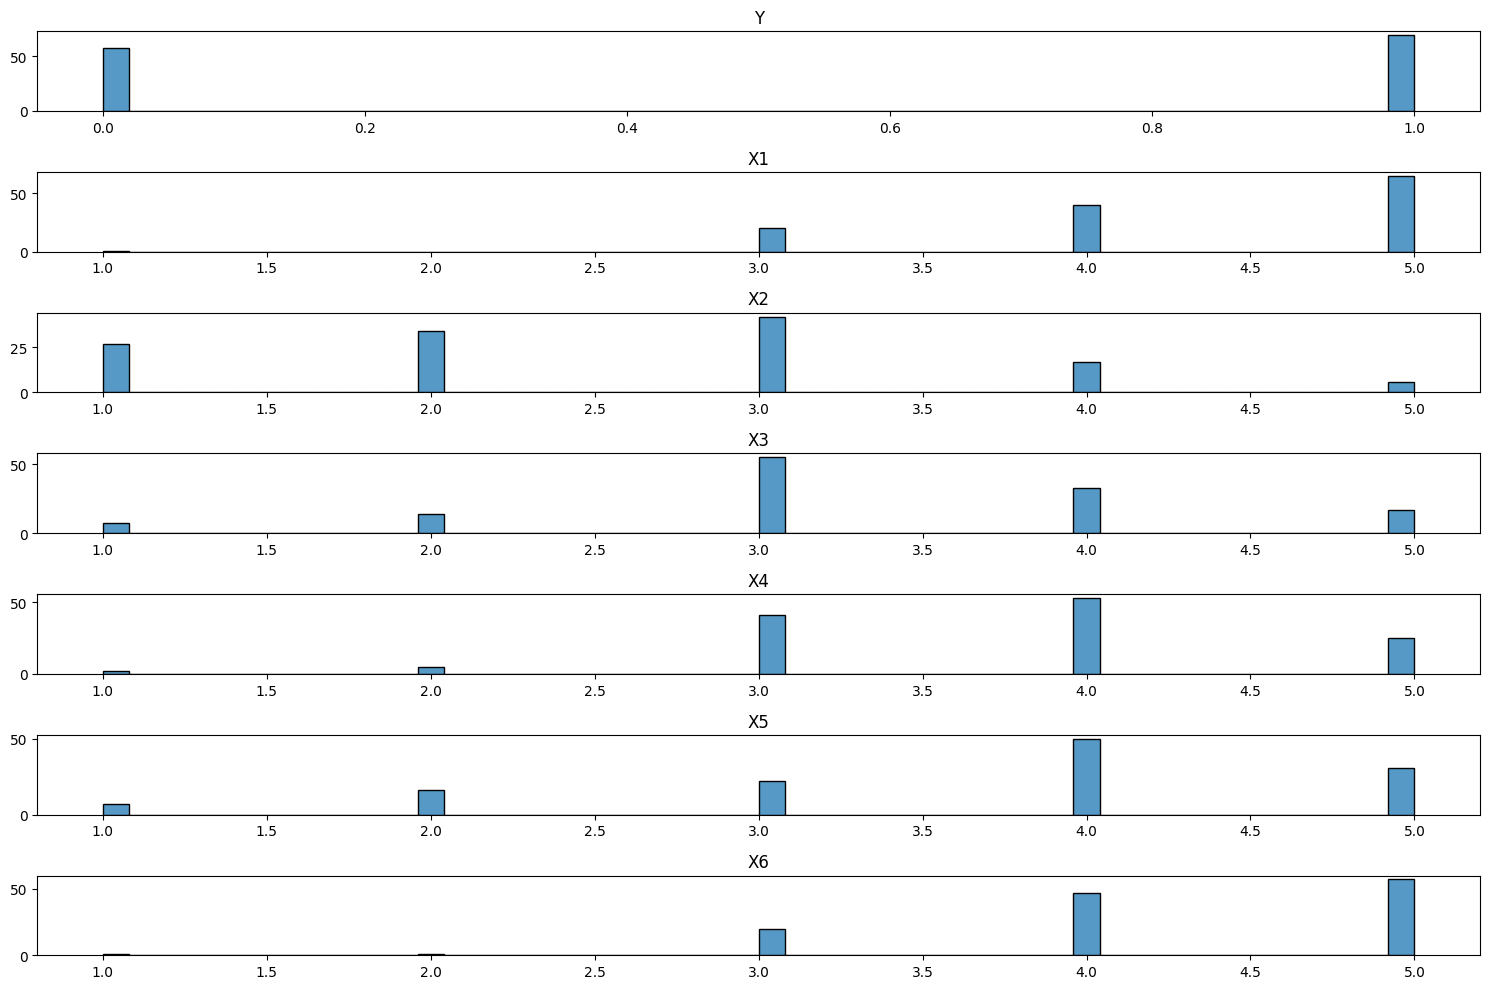

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(figsize=(15,10), ncols=1, nrows=7)
axes = axes.flatten()

for i, ax in enumerate(axes):
    sns.histplot(data = df.iloc[:, i], bins=50, ax=ax)
    ax.set_title(df.iloc[:,i].name)
    ax.set_ylabel("")
    ax.set_xlabel("")

plt.tight_layout()
plt.show()

##### Comments

The first thing to note is that the scale of all our feature variables is the same (1-5). Above, we can clearly see that the distributions of the X1, X4, X5 and X6 variables are skewed to the right. The distribution of the X2 is slightly skewed to the left. The distribution of the X3 variable is most normally distributed.

Furthermore, we can note that there are very few instances of X1 = 1,2 and X6 = 1,2. Below, we calculate the exact number of these instances.


In [11]:
df["X1"].value_counts()

X1
5    65
4    40
3    20
1     1
Name: count, dtype: int64

In [12]:
df["X6"].value_counts()

X6
5    57
4    47
3    20
2     1
1     1
Name: count, dtype: int64

##### Correlation Table

Below we plot the correlation heatmap. Interestingly, there are no two variables which appear strongly correlated. The hightest correlation coefficient value in the heatmap is only 0.43 (between X1 and X5). Therefore, no clear relationship between any two variables stands out in this heatmap. Looking at the row corresponding to Y, we see that the correlation coefficients between Y and X2, and Y and X4 are particularly close to zero.

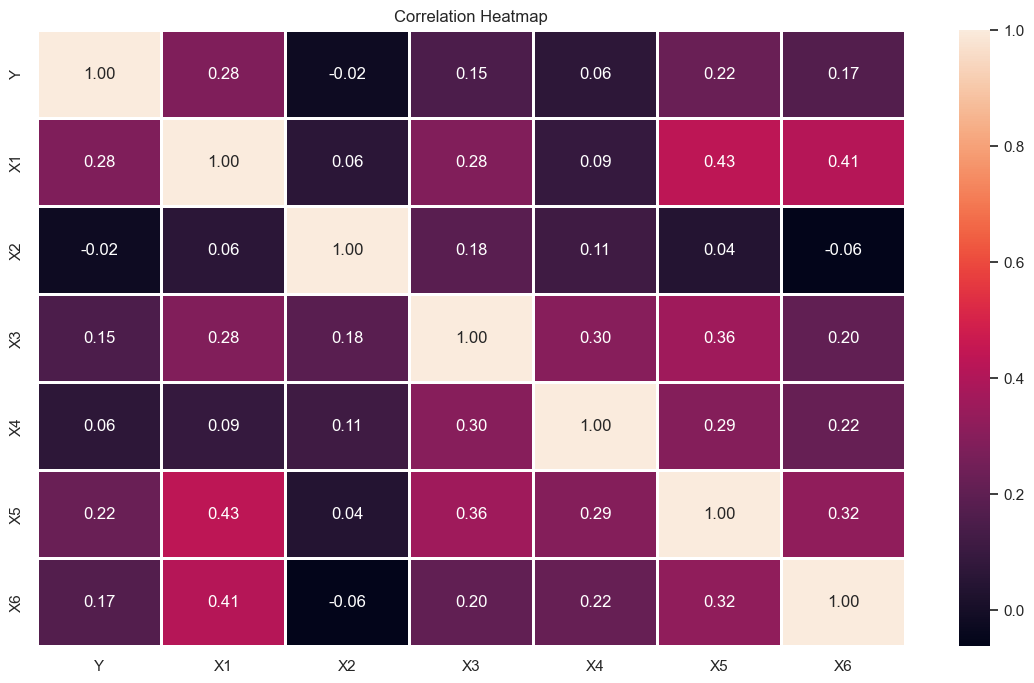

In [13]:
sns.set(rc={'figure.figsize': (14, 8)})
sns.heatmap(df.corr(), annot = True, fmt = '.2f', linewidths = 2)
plt.title("Correlation Heatmap")
plt.show()

#### **EDA Comments**

From the EDA, we have learned a lot about the dataset. One of the most important takeaways is that the startup is performing poorly. The number of dissatisfied and satisfied customers is fairly evenly split. Thus, it is imperative that the startup improves customer satisfaction. To this end, we will design a classification machine learning model which will attempt to model customer satisfaction given values of the feature variables.

Below is a table describing the main takeaways from the EDA, with their corresponding consequences for our models.

| Issue    | Consequences for Model |
|----------|----------|
| Fairly even split between Y = 0 and Y = 1 cases | As dataset is balanced, there is no need to perform upsampling. Furthermore, recall for unhappy customers should be used as model score to optimize, as it is imperative that we classify unhappy customers correctly, to understand what is driving their discontent.  |
| Feature variables are all on same scale (1-5) | No need to perform feature engineering on feature scale |
| Few instances of X1 = 1,2 and X6 = 1,2 | Consider removing these datapoints, as they could cause issues down the line | 
| Correlation coefficients between Y and X2, and Y and X4 are close to zero | Consider removing features X2 and/or X4, to make feature space smaller | 

#### **Data Clean Up and Feature Engineering**

In our EDA, we saw that the dataset was fairly straightforward and required little clean up or feature engineering. The only potential feature engineering step that could be included in our model pipelines is to remove the feature variables X2 and/or X4. Below, we will try three cases: with X2 and X4, without X2, and without X2 and X4. 

In [ ]:
'''
X = df.drop('Y', axis = 1)
Y = df["Y"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify = Y, random_state=seed)

X_train_ = X_train.drop('X2', axis = 1)
X_test_ = X_test.drop('X2', axis = 1)

X_train_red = X_train_.drop('X4', axis = 1)
X_test_red = X_test_.drop('X4', axis = 1)
'''



Classification models can exhibit high degrees of sensitivity to training and test datasets, when working with small datasets. As our dataset is small, it is adviseable to save the test and training datasets, so that the same sets are used each time for every model.

In [36]:
'''
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)


X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False, header=True)
y_test.to_csv("y_test.csv", index=False, header=True)

X_train_.to_csv("X_train_.csv", index=False)
X_test_.to_csv("X_test_.csv", index=False)

X_train_red.to_csv("X_train_red.csv", index=False)
X_test_red.to_csv("X_test_red.csv", index=False)

'''


Reading datasets

In [8]:
import pandas as pd

X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")

y_train = pd.read_csv("y_train.csv").squeeze("columns")  # Use `squeeze=True` to load as Series
y_test = pd.read_csv("y_test.csv").squeeze("columns")

X_train_ = pd.read_csv("X_train_.csv")
X_test_ = pd.read_csv("X_test_.csv")

X_train_red = pd.read_csv("X_train_red.csv")
X_test_red = pd.read_csv("X_test_red.csv")



#### Lazy Predict

To gain some idea as to which classification models will likely perform better for our dataset, we will use Lazy Predict. 

##### Full dataset

In [48]:


# Define specificity function
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else 0

# Initialize LazyClassifier with the custom specificity function
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=specificity_score)

# Fit models and get results
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# Display results
print(models)



  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:02<00:00, 12.65it/s]

[LightGBM] [Info] Number of positive: 55, number of negative: 45
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.550000 -> initscore=0.200671
[LightGBM] [Info] Start training from score 0.200671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

##### Dataset without X2 feature

In [49]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=specificity_score)
models, predictions = clf.fit(X_train_, X_test_, y_train, y_test)

print(models)

  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:02<00:00, 11.92it/s]

[LightGBM] [Info] Number of positive: 55, number of negative: 45
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.550000 -> initscore=0.200671
[LightGBM] [Info] Start training from score 0.200671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

##### Dataset without X2 and X4 features

In [50]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=specificity_score)
models, predictions = clf.fit(X_train_red, X_test_red, y_train, y_test)

print(models)

100%|██████████| 32/32 [00:02<00:00, 12.99it/s]

[LightGBM] [Info] Number of positive: 55, number of negative: 45
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.550000 -> initscore=0.200671
[LightGBM] [Info] Start training from score 0.200671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

##### **Analysis of Lazy Predict Results**

Above, we have seen that the optimal model depends on the dataset. Furthermore, we have seen that working with a reduced dataset (without X2 and X4 feature) appears to improve model performance according to the accuracy, roc auc and F1 scores. However, there is a less significant improvement in model performance if we look at the specififity/negative recall score. As stated previously, as the main goal of the project is to identify unhappy customers, the specificity/negative recall score will be the main score we will be working with. Furthermore, it is worth noting that none of the models appear to perform that well according to the predictions of Lazy Predict. Thus, the problem at hand is non-trivial. 

As working with any of the two reduced datasets above appears to offer minimal improvement in specificity/negative recall scores, it would unwise at the point to work with these reduced datasets. Therefore, we will continue working with the full dataset. However, for each model, we will implement Recursive Feature Elimination in each of our models to see whether a different reduced dataset offers any advantages. Therefore, the Lazy Predict results above may give us some clues as to which models may work better with a reduced dataset.

Given the time constraints of the project, it is not possible to investigate all the permutations of the different models and datasets. After consulting the top performing models in the above tables, I note that tree models are common. Thus it makes sense to mostly work with these types of models. We will work with a decision tree model (which can be viewed as our baseline model), bagging classifier, random forest and Adaboost. Furthermore, to not have all our eggs in one basket, we will work with other models that aren't tree models. After consulting the results above, we note that the BernoulliNB and Logistic Regression models score well. Thus, we will also work with these classification models.

#### **Decision Tree Model**

##### Hyperparmater optimization using hyperopt

In [17]:


# Define the custom scorer focusing on negative recall
negative_recall = make_scorer(recall_score, pos_label=0)

# Define the objective function
def objective(params):
    # the number of features, ensuring it is an integer
    n_features = int(params['n_features'])
    
    # Set up classifier hyperparameters 
    dt_params = {
        'max_depth': int(params['max_depth']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'class_weight': params['class_weight'],
        'criterion': params['criterion'],
        'random_state': int(params['random_state']),
    }


    classifier_for_rfe = DecisionTreeClassifier(**dt_params)
    
    # Set up the RFE with the classifier as the estimator
    rfe = RFE(estimator=classifier_for_rfe, n_features_to_select=n_features)
    
    classifier_final = DecisionTreeClassifier(**dt_params)

    # Create a pipeline that first does feature selection, then classification
    pipeline = Pipeline(steps=[('rfe', rfe), ('clf', classifier_final)])
    
    # Use cross-validation to evaluate performance using negative recall
    score = cross_val_score(pipeline, X_train, y_train, scoring=negative_recall, cv=5).mean()
    
    # Hyperopt minimizes the objective, so return the negative score (to maximize negative recall)
    return {'loss': -score, 'status': STATUS_OK}

# Define the hyperparameter search space using hp.choice for discrete parameters
search_space = {
    'n_features': hp.choice('n_features', list(np.arange(1, 7, 1, dtype=int))),
    'max_depth': hp.choice('max_depth', list(np.arange(3, 15, 1, dtype=int))),
    'min_samples_split': hp.choice('min_samples_split', list(np.arange(2, 10, 1, dtype=int))),
    'min_samples_leaf': hp.choice('min_samples_leaf', list(np.arange(1, 8, 1, dtype=int))),
    'class_weight': hp.choice('class_weight', [None, "balanced"]),
    'criterion': hp.choice('criterion', ["gini", "entropy"]),
    'random_state': hp.choice('random_state', [seed])  # Ensure 'seed' is defined
}

# Run Hyperopt
trials = Trials()
best = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=500,
    trials=trials
)

best_params = space_eval(search_space, best)
print("Best hyperparameters:", best_params)


  0%|          | 0/500 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 500/500 [01:15<00:00,  6.65trial/s, best loss: -0.7555555555555555]
Best hyperparameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': np.int64(3), 'min_samples_leaf': np.int64(2), 'min_samples_split': np.int64(3), 'n_features': np.int64(3), 'random_state': 7980}


Optimal hyperparmaters are saved below.

In [23]:
best_params =  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': np.int64(3), 'min_samples_leaf': np.int64(2), 'min_samples_split': np.int64(3), 'n_features': np.int64(3), 'random_state': seed}
n_features = int(best_params['n_features'])
del best_params['n_features']



classifier_for_rfe = DecisionTreeClassifier(**best_params)
    
# Set up the RFE with the classifier as the estimator
rfe = RFE(estimator=classifier_for_rfe, n_features_to_select=n_features)

classifier_final = DecisionTreeClassifier(**best_params)


# Create a pipeline that first does feature selection, then classification
dtc_pipeline = Pipeline(steps=[('rfe', rfe), ('clf', classifier_final)])
dtc_pipeline.fit(X_train, y_train)


mask = dtc_pipeline.named_steps['rfe'].support_
selected_feature_names = X_train.columns[mask]
print("Selected features:", selected_feature_names)



Selected features: Index(['X1', 'X3', 'X6'], dtype='object')


Visualizing tree

In [24]:
from sklearn.tree import export_text
tree_text = export_text(dtc_pipeline[-1], feature_names=selected_feature_names, max_depth=3)
print(tree_text)

|--- X1 <= 4.50
|   |--- X6 <= 3.50
|   |   |--- X3 <= 3.50
|   |   |   |--- class: 0
|   |   |--- X3 >  3.50
|   |   |   |--- class: 0
|   |--- X6 >  3.50
|   |   |--- X3 <= 4.50
|   |   |   |--- class: 0
|   |   |--- X3 >  4.50
|   |   |   |--- class: 0
|--- X1 >  4.50
|   |--- X3 <= 3.50
|   |   |--- X6 <= 4.50
|   |   |   |--- class: 1
|   |   |--- X6 >  4.50
|   |   |   |--- class: 0
|   |--- X3 >  3.50
|   |   |--- X6 <= 4.50
|   |   |   |--- class: 1
|   |   |--- X6 >  4.50
|   |   |   |--- class: 1



Confusion matrix for results of model performance on test data

              precision    recall  f1-score   support

           0       0.50      0.92      0.65        12
           1       0.75      0.21      0.33        14

    accuracy                           0.54        26
   macro avg       0.62      0.57      0.49        26
weighted avg       0.63      0.54      0.48        26



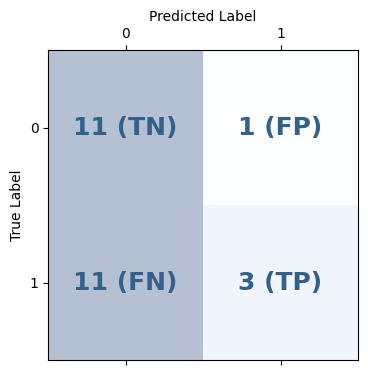

False Positive Rate (FPR): 0.083
Recall: 0.214
Negative Recall: 0.917
Precision: 0.750
F1 Score: 0.333


In [25]:
y_probs = dtc_pipeline.predict_proba(X_test)[:, 1]
y_pred = dtc_pipeline.predict(X_test)

# get the confusion matrix as a numpy array
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
# use the pretty function to make it nicer

LE = LabelEncoder()
y_train = LE.fit_transform(y_train)
y_test = LE.transform(y_test)
FP_i = [0,1]
TN_i = [0,0]
TP_i = [1,1]
FN_i = [1,0]

# Extracting the quantities from the confusion matrix 
FP = confmat[0,1]
TN = confmat[0,0]
TP = confmat[1,1]
FN = confmat[1,0]

#Calculation of FPR, Recall, Precision and F1 Score
# FPR
FPR = (FP)/(FP+TN)
# Recall
Recall = (TP)/(TP+FN)
Negative_Recall = (TN)/(TN+FP)

# Precision
Precision = (TP)/(FP+TP)
# F1 Score
F1 = 2 * (Precision * Recall)/(Precision + Recall)

print(classification_report(y_test, y_pred))

pretty_confusion_matrix(confmat, LE.classes_, "",
                        labeling=True, highlight_indexes = [FP_i,FN_i,TP_i,TN_i])

print('False Positive Rate (FPR): '+ '%.3f' % FPR)
print('Recall: '+ '%.3f' % Recall)
print('Negative Recall: '+'%.3f' % Negative_Recall)
print('Precision: '+ '%.3f' % Precision)
print('F1 Score: '+ '%.3f' % F1)

Feature importance

NameError: name 'fig' is not defined

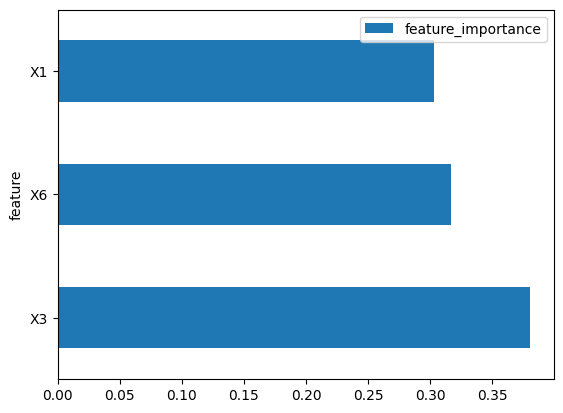

In [27]:
def plot_feature_importance(model, names, threshold = None):
    feature_importance_df = pd.DataFrame.from_dict({'feature_importance': model.feature_importances_[:len(names)],
                                                    'feature': names})\
            .set_index('feature').sort_values('feature_importance', ascending = False)

    if threshold is not None:
        feature_importance_df = feature_importance_df[feature_importance_df.feature_importance > threshold]

    feature_importance_df.plot(kind="barh")
    fig.show()

plot_feature_importance(dtc_pipeline[-1], selected_feature_names)

ROC curve 

AUC value: 0.6011904761904762


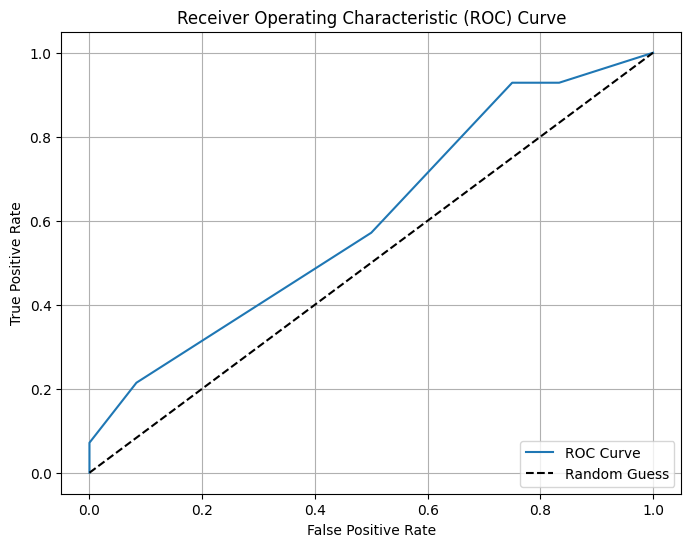

In [28]:
predictions_pa = dtc_pipeline.predict_proba(X_test)

roc_calc = roc_curve(y_true = y_test, y_score = predictions_pa[:,1])
roc = pd.DataFrame(
    data = np.c_[roc_calc],
    columns = ('false positive rate', 'true positive rate', 'threshold')
)
print("AUC value:", roc_auc_score(y_true = y_test, y_score = predictions_pa[:,1]))

# Compute precision-recall curve
baseline_precision, baseline_recall, thresholds = precision_recall_curve(y_test, predictions_pa[:,1])

# Compute area under the curve (AUC)
baseline_auc_score = auc(baseline_recall, baseline_precision)

plot_roc_curve(roc)

#### **Bagging Model**

Hyperparameter optimization using hyperopt

In [47]:
from sklearn.ensemble import BaggingClassifier

def bag_importance_getter(estimator):
    # Ensure the BaggingClassifier is fitted so that `estimators_` is available.
    # Average the feature importances from each decision tree.
    importances = np.array([tree.feature_importances_ for tree in estimator.estimators_])
    return np.mean(importances, axis=0)

def objective(params):
    # the number of features, ensuring it is an integer
    n_features = int(params['n_features'])

    bag_params = {
        "n_estimators": params['n_estimators'],    # single integer
        "max_samples": params['max_samples'],        # single float
        "max_features": params['max_features'],      # single float
        "bootstrap": params['bootstrap'],            # single boolean
        "random_state": params['random_state']       # seed value
    }
    
    dt_params = {
        "max_depth": params['dt_max_depth'],            # single integer
        "min_samples_split": params['dt_min_samples_split'],  # single integer
        "min_samples_leaf": params['dt_min_samples_leaf'],    # single integer
        "criterion": params['dt_criterion'],            # single string
        "class_weight": params['dt_class_weight']       # either None or "balanced"
    }


    classifier_for_rfe = BaggingClassifier(
        estimator=DecisionTreeClassifier(**dt_params),
        **bag_params
    )

    rfe = RFE(estimator=classifier_for_rfe, 
                n_features_to_select=n_features,
                importance_getter=bag_importance_getter)

    classifier_final = BaggingClassifier(
            estimator=DecisionTreeClassifier(**dt_params),
            **bag_params
        )
        # Create a pipeline that first does feature selection, then classification
    bag_pipeline = Pipeline(steps=[('rfe', rfe), 
                    ('model', classifier_final)])
    # Use cross-validation to evaluate performance using negative recall
    score = cross_val_score(bag_pipeline, X_train, y_train, scoring=negative_recall, cv=5).mean()
    
    # Hyperopt minimizes the objective, so return the negative score (to maximize negative recall)
    return {'loss': -score, 'status': STATUS_OK}


# Define the hyperparameter search space using hp.choice for discrete parameters
search_space = {
    # number of features
    'n_features': hp.choice('n_features', list(np.arange(1, 7, 1, dtype=int))),
    # bagging hyperparams
    'n_estimators' : hp.choice('n_estimators', list(np.arange(10, 30, 10, dtype=int))),
    'max_samples' : hp.choice('max_samples', [0.5, 0.7, 1.0]),
    'max_features' : hp.choice('max_features', [1.0]),
    'bootstrap' : hp.choice('bootstrap', [True, False]),
    'random_state' : hp.choice('random_state', [seed]),
    # decision tree hyperparams
    'dt_max_depth' : hp.choice('dt_max_depth', list(np.arange(7, 14, 1, dtype=int))),
    'dt_min_samples_split' : hp.choice('dt_min_samples_split', list(np.arange(4, 8, 1, dtype=int))),
    'dt_min_samples_leaf' : hp.choice('dt_min_samples_leaf', list(np.arange(1, 4, 1, dtype=int))),
    'dt_criterion' : hp.choice('dt_criterion', ['gini','entropy']),
    'dt_class_weight' : hp.choice('dt_class_weight', [None, "balanced"])

}
trials = Trials()
best = fmin(
    fn = objective,
    space = search_space,
    algo = tpe.suggest,
    max_evals=500,
    trials = trials
)

best_params = space_eval(search_space, best)
print("Best hyperparameters:", best_params)

100%|██████████| 500/500 [19:18<00:00,  2.32s/trial, best loss: -0.7333333333333334]
Best hyperparameters: {'bootstrap': True, 'dt_class_weight': 'balanced', 'dt_criterion': 'entropy', 'dt_max_depth': np.int64(8), 'dt_min_samples_leaf': np.int64(2), 'dt_min_samples_split': np.int64(5), 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': np.int64(10), 'n_features': np.int64(1), 'random_state': 7980}


optimal hyperparameters

In [48]:

dt_params = {k: v for k, v in best_params.items() if k.startswith('dt_')}
dt_params = {
    (k[len('dt_'):] if k.startswith('dt_') else k): v
    for k, v in dt_params.items()
}

bag_params = {k: v for k, v in best_params.items() if not k.startswith('dt_')}
n_features = int(bag_params['n_features'])
del bag_params['n_features']



classifier_for_rfe = BaggingClassifier(
        estimator=DecisionTreeClassifier(**dt_params),
        **bag_params
    )

rfe = RFE(estimator=classifier_for_rfe, 
              n_features_to_select=n_features,
              importance_getter=bag_importance_getter)

classifier_final = BaggingClassifier(
        estimator=DecisionTreeClassifier(**dt_params),
        **bag_params
    )
    # Create a pipeline that first does feature selection, then classification
bag_pipeline = Pipeline(steps=[('rfe', rfe), 
                ('model', classifier_final)])

bag_pipeline.fit(X_train,y_train)

mask = bag_pipeline.named_steps['rfe'].support_
selected_feature_names_bag = X_train.columns[mask]
print("Selected features:", selected_feature_names_bag)


Selected features: Index(['X2'], dtype='object')


Below I have plotted feature importance. As can be seen X3 and X1 features appear to be, again, the most important features in our model.

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Extract the BaggingClassifier from the pipeline
bagging_model = bag_pipeline.named_steps["model"]

# Check if the base estimator has feature importances
if hasattr(bagging_model.estimators_[0], "feature_importances_"):
    # Average feature importances across all base estimators
    feature_importances = np.mean(
        [tree.feature_importances_ for tree in bagging_model.estimators_], axis=0
    )

    # Create a DataFrame for feature importance ranking
    feature_names = X_train.columns  
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": feature_importances
    }).sort_values(by="Importance", ascending=False)

    # Print feature rankings
    print("Feature Importances:")
    print(importance_df)

    # Visualize feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
    plt.gca().invert_yaxis()
    plt.title("Feature Importances from Bagging Model")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()
else:
    print("The base estimator does not support feature importances.")


ValueError: All arrays must be of the same length

Below is the ROC curve for this model. As can be seen, model performs only marginally better than a random guess.

AUC value: 0.5327380952380952


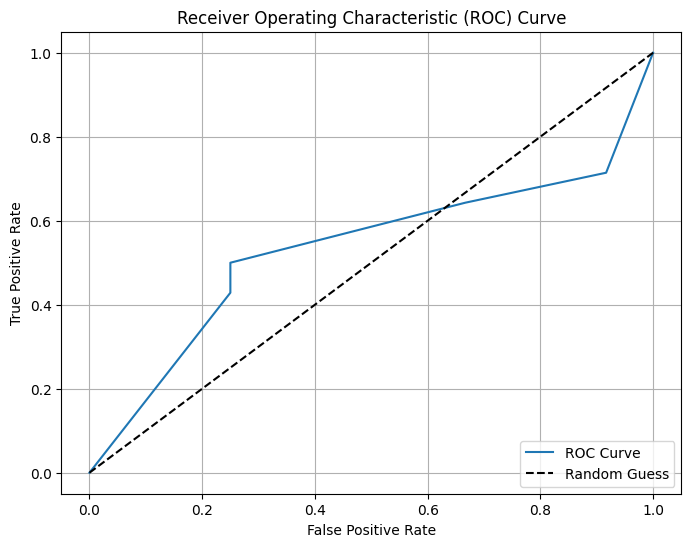

In [50]:
predictions_pa = bag_pipeline.predict_proba(X_test)

roc_calc = roc_curve(y_true = y_test, y_score = predictions_pa[:,1])
roc = pd.DataFrame(
    data = np.c_[roc_calc],
    columns = ('false positive rate', 'true positive rate', 'threshold')
)
print("AUC value:", roc_auc_score(y_true = y_test, y_score = predictions_pa[:,1]))

# Compute precision-recall curve
baseline_precision, baseline_recall, thresholds = precision_recall_curve(y_test, predictions_pa[:,1])

# Compute area under the curve (AUC)
baseline_auc_score = auc(baseline_recall, baseline_precision)

plot_roc_curve(roc)

Below, is the confusion matrix for the model results on the test data. As can be seen, the model classifies 67% of the negative cases correctly. Thus, it performs tolerably well at classifying negative cases. It performs less well at classifying positive cases (recall of 57%). 

              precision    recall  f1-score   support

           0       0.56      0.75      0.64        12
           1       0.70      0.50      0.58        14

    accuracy                           0.62        26
   macro avg       0.63      0.62      0.61        26
weighted avg       0.64      0.62      0.61        26



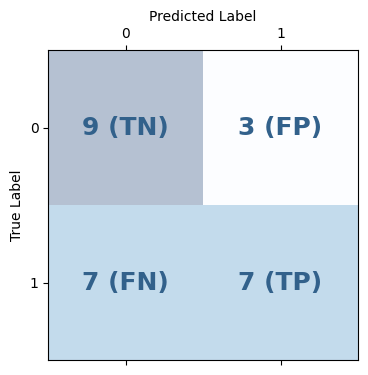

False Positive Rate (FPR): 0.250
Recall: 0.500
Negative Recall: 0.750
Precision: 0.700
F1 Score: 0.583


In [51]:
y_probs = bag_pipeline.predict_proba(X_test)[:, 1]
y_pred = bag_pipeline.predict(X_test)

# get the confusion matrix as a numpy array
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
# use the pretty function to make it nicer

LE = LabelEncoder()
y_train = LE.fit_transform(y_train)
y_test = LE.transform(y_test)
FP_i = [0,1]
TN_i = [0,0]
TP_i = [1,1]
FN_i = [1,0]

# Extracting the quantities from the confusion matrix 
FP = confmat[0,1]
TN = confmat[0,0]
TP = confmat[1,1]
FN = confmat[1,0]

#Calculation of FPR, Recall, Precision and F1 Score
# FPR
FPR = (FP)/(FP+TN)
# Recall
Recall = (TP)/(TP+FN)
# Negative recall
Negative_Recall = (TN)/(TN+FP)
# Precision
Precision = (TP)/(FP+TP)
# F1 Score
F1 = 2 * (Precision * Recall)/(Precision + Recall)

print(classification_report(y_test, y_pred))

pretty_confusion_matrix(confmat, LE.classes_, "",
                        labeling=True, highlight_indexes = [FP_i,FN_i,TP_i,TN_i])

print('False Positive Rate (FPR): '+ '%.3f' % FPR)
print('Recall: '+ '%.3f' % Recall)
print('Negative Recall: '+'%.3f' % Negative_Recall)

print('Precision: '+ '%.3f' % Precision)
print('F1 Score: '+ '%.3f' % F1)

# **Random forests**

In [25]:
from sklearn.ensemble import RandomForestClassifier

negative_recall = make_scorer(recall_score, pos_label=0)


def objective(params):

    n_features = int(params['n_features'])

    rf_params = {
        
        "n_estimators": params['n_estimators'],  # Number of trees in the forest
        "max_depth": params['max_depth'],  # Maximum depth of trees
        "min_samples_split": params['min_samples_split'],  # Minimum samples required to split
        "min_samples_leaf": params['min_samples_leaf'],  # Minimum samples required at a leaf node
        "max_features": params['max_features'],  # Number of features to consider for the best split
        "criterion": params['criterion'],
        "max_samples": params['max_samples'],
        "bootstrap": params['bootstrap'],  # Whether to bootstrap samples
        "class_weight": params['class_weight'],  # Adjust weights for imbalanced classes
        "random_state": params['random_state']  # Random state for reproducibility

    }

    

    # Create a pipeline that first does feature selection, then classification

    classifier_for_rfe = RandomForestClassifier(**rf_params)

    rfe = RFE(estimator=classifier_for_rfe, 
              n_features_to_select=n_features)

    classifier_final = RandomForestClassifier(**rf_params)

    pipeline = Pipeline(steps= [('rfe',rfe),('clf',classifier_final)])
    score = cross_val_score(pipeline, X_train, y_train, scoring = negative_recall, cv=5).mean()
    return {'loss': -score, 'status': STATUS_OK}

search_space = {
    "n_features" : hp.choice('n_features', [1,2,3,4,5]),
    "n_estimators": hp.choice('n_estimators', [10]),  # Number of trees in the forest
    "max_depth": hp.choice('max_depth', [None] + list(np.arange(7, 14, 1))),  # Maximum depth of trees
    "min_samples_split": hp.choice('min_samples_split', list(np.arange(2, 6, 1))),  # Minimum samples required to split
    "min_samples_leaf": hp.choice('min_samples_leaf', list(np.arange(1, 4, 1))),  # Minimum samples required at a leaf node
    "max_features": hp.choice('max_features', ["sqrt", "log2", None]),  # Number of features to consider for the best split
    "criterion": hp.choice('criterion', ["gini", "entropy"]),
    "max_samples": hp.choice('max_samples',[0.5, 0.7, 1.0]),
    "bootstrap": hp.choice('bootstrap',[True]),  # Whether to bootstrap samples
    "class_weight": hp.choice('class_weight', [None, "balanced"]),  # Adjust weights for imbalanced classes
    "random_state": hp.choice('random_state',[seed])  # Random state for reproducibility

}

trials = Trials()
best = fmin(
    fn = objective,
    space = search_space,
    algo = tpe.suggest,
    max_evals=20,
    trials = trials
)

best_params = space_eval(search_space, best)
print("Best hyperparameters:", best_params)


  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 20/20 [00:19<00:00,  1.03trial/s, best loss: -0.6666666666666666]
Best hyperparameters: {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': np.int64(12), 'max_features': 'sqrt', 'max_samples': 1.0, 'min_samples_leaf': np.int64(2), 'min_samples_split': np.int64(5), 'n_estimators': 10, 'n_features': 4, 'random_state': 7980}


In [27]:
import copy

rf_params = copy.deepcopy(best_params)
n_features = int(rf_params['n_features'])
del rf_params['n_features']


classifier_for_rfe = RandomForestClassifier(**rf_params)

rfe = RFE(estimator=classifier_for_rfe, 
            n_features_to_select=n_features)

classifier_final = RandomForestClassifier(**rf_params)

rf_pipeline = Pipeline(steps= [('rfe',rfe),('clf',classifier_final)])

rf_pipeline.fit(X_train,y_train)

mask = rf_pipeline.named_steps['rfe'].support_
selected_feature_names_rf = X_train.columns[mask]

print("Selected features:", selected_feature_names_rf)

Selected features: Index(['X1', 'X3', 'X4', 'X5'], dtype='object')


Feature Importances:
  Feature  Importance
1      X3        0.35
0      X1        0.27
3      X5        0.26
2      X4        0.12


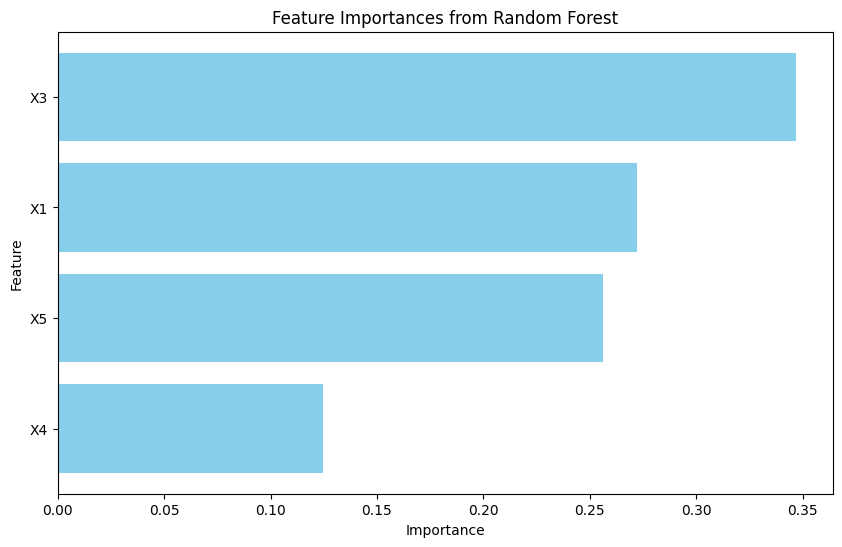

In [29]:
# Extract the RandomForestClassifier from the pipeline
rf_model = rf_pipeline.named_steps["clf"]

# Check if the model has feature_importances_ attribute
if hasattr(rf_model, "feature_importances_"):
    # Get feature importances
    feature_importances = rf_model.feature_importances_

    # Create a DataFrame for feature importance ranking
    importance_df = pd.DataFrame({
        "Feature": selected_feature_names_rf,
        "Importance": feature_importances
    }).sort_values(by="Importance", ascending=False)

    # Print feature rankings
    print("Feature Importances:")
    print(importance_df)

    # Visualize feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
    plt.gca().invert_yaxis()
    plt.title("Feature Importances from Random Forest")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()
else:
    print("The model does not support feature importances.")


Negative Recall: 0.667
              precision    recall  f1-score   support

           0       0.50      0.67      0.57        12
           1       0.60      0.43      0.50        14

    accuracy                           0.54        26
   macro avg       0.55      0.55      0.54        26
weighted avg       0.55      0.54      0.53        26



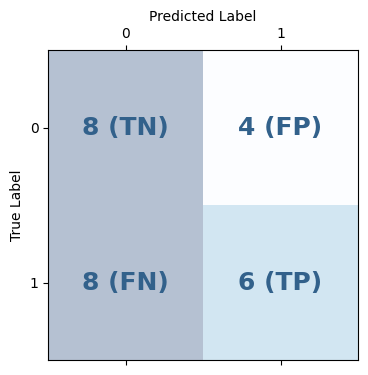

False Positive Rate (FPR): 0.333
Recall: 0.429
Negative Recall: 0.667
Precision: 0.600
F1 Score: 0.500


In [30]:
y_probs = rf_pipeline.predict_proba(X_test)[:, 1]
y_pred = rf_pipeline.predict(X_test)

# get the confusion matrix as a numpy array
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
# use the pretty function to make it nicer

LE = LabelEncoder()
y_train = LE.fit_transform(y_train)
y_test = LE.transform(y_test)
FP_i = [0,1]
TN_i = [0,0]
TP_i = [1,1]
FN_i = [1,0]

# Extracting the quantities from the confusion matrix 
FP = confmat[0,1]
TN = confmat[0,0]
TP = confmat[1,1]
FN = confmat[1,0]

#Calculation of FPR, Recall, Precision and F1 Score
# FPR
FPR = (FP)/(FP+TN)
# Recall
Recall = (TP)/(TP+FN)
Negative_Recall = (TN)/(TN+FP)
print('Negative Recall: '+'%.3f' % Negative_Recall)


# Precision
Precision = (TP)/(FP+TP)
# F1 Score
F1 = 2 * (Precision * Recall)/(Precision + Recall)

print(classification_report(y_test, y_pred))

pretty_confusion_matrix(confmat, LE.classes_, "",
                        labeling=True, highlight_indexes = [FP_i,FN_i,TP_i,TN_i])

print('False Positive Rate (FPR): '+ '%.3f' % FPR)
print('Recall: '+ '%.3f' % Recall)
print('Negative Recall: '+'%.3f' % Negative_Recall)

print('Precision: '+ '%.3f' % Precision)
print('F1 Score: '+ '%.3f' % F1)

AUC value: 0.5089285714285714


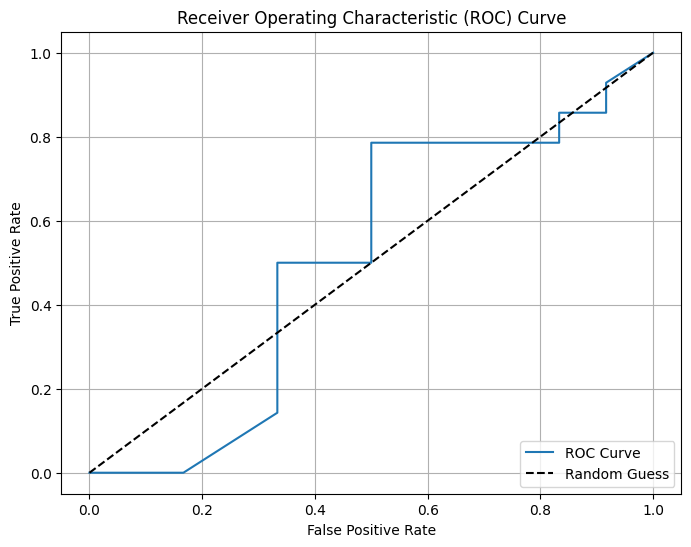

In [31]:
predictions_pa = rf_pipeline.predict_proba(X_test)

roc_calc = roc_curve(y_true = y_test, y_score = predictions_pa[:,1])
roc = pd.DataFrame(
    data = np.c_[roc_calc],
    columns = ('false positive rate', 'true positive rate', 'threshold')
)
print("AUC value:", roc_auc_score(y_true = y_test, y_score = predictions_pa[:,1]))

# Compute precision-recall curve
baseline_precision, baseline_recall, thresholds = precision_recall_curve(y_test, predictions_pa[:,1])

# Compute area under the curve (AUC)
baseline_auc_score = auc(baseline_recall, baseline_precision)

plot_roc_curve(roc)

### **Adaboost**

In [37]:
from sklearn.ensemble import AdaBoostClassifier

def bag_importance_getter(estimator):
    # Ensure the BaggingClassifier is fitted so that `estimators_` is available.
    # Average the feature importances from each decision tree.
    importances = np.array([tree.feature_importances_ for tree in estimator.estimators_])
    return np.mean(importances, axis=0)

def objective(params):
    # the number of features, ensuring it is an integer
    n_features = int(params['n_features'])

    ada_params = {
        "n_estimators": params['n_estimators'],    # single integer
        "learning_rate": params['learning_rate'],        # single float
        "random_state": params['random_state']       # seed value
    }
    
    dt_params = {
        "max_depth": params['dt_max_depth'],            # single integer
        "min_samples_split": params['dt_min_samples_split'],  # single integer
        "min_samples_leaf": params['dt_min_samples_leaf'],    # single integer
        "criterion": params['dt_criterion'],            # single string
        "class_weight": params['dt_class_weight']       # either None or "balanced"
    }


    classifier = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(**dt_params),
        **ada_params
    )
    
    # Set up the RFE with the classifier as the estimator
    rfe = RFE(estimator=classifier, 
              n_features_to_select=n_features,
              importance_getter=bag_importance_getter)
    
    # Create a pipeline that first does feature selection, then classification
    pipeline = Pipeline(steps=[('rfe', rfe), ('clf', classifier)])
    # Use cross-validation to evaluate performance using negative recall
    score = cross_val_score(pipeline, X_train, y_train, scoring=negative_recall, cv=5).mean()
    
    # Hyperopt minimizes the objective, so return the negative score (to maximize negative recall)
    return {'loss': -score, 'status': STATUS_OK}


# Define the hyperparameter search space using hp.choice for discrete parameters
search_space = {
    # number of features
    'n_features': hp.choice('n_features', list(np.arange(1, 7, 1, dtype=int))),
    # ada hyperparams
    'n_estimators' : hp.choice('n_estimators', list(np.arange(10, 100, 10, dtype=int))),
    'learning_rate' : hp.choice('learning_rate', list(np.arange(1,101,10, dtype=int))),
    'random_state' : hp.choice('random_state', [seed]),
    # decision tree hyperparams
    'dt_max_depth' : hp.choice('dt_max_depth', list(np.arange(7, 14, 1, dtype=int))),
    'dt_min_samples_split' : hp.choice('dt_min_samples_split', list(np.arange(4, 8, 1, dtype=int))),
    'dt_min_samples_leaf' : hp.choice('dt_min_samples_leaf', list(np.arange(1, 4, 1, dtype=int))),
    'dt_criterion' : hp.choice('dt_criterion', ['gini','entropy']),
    'dt_class_weight' : hp.choice('dt_class_weight', [None, "balanced"])
}

trials = Trials()
best = fmin(
    fn = objective,
    space = search_space,
    algo = tpe.suggest,
    max_evals=20,
    trials = trials
)

best_params = space_eval(search_space, best)
print("Best hyperparameters:", best_params)

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 20/20 [00:40<00:00,  2.03s/trial, best loss: -0.8444444444444444]
Best hyperparameters: {'dt_class_weight': None, 'dt_criterion': 'gini', 'dt_max_depth': np.int64(13), 'dt_min_samples_leaf': np.int64(1), 'dt_min_samples_split': np.int64(4), 'learning_rate': np.int64(21), 'n_estimators': np.int64(20), 'n_features': np.int64(1), 'random_state': 7980}


In [40]:
dt_params = {k: v for k, v in best_params.items() if k.startswith('dt_')}
dt_params = {
    (k[len('dt_'):] if k.startswith('dt_') else k): v
    for k, v in dt_params.items()
}

ada_params = {k: v for k, v in best_params.items() if not k.startswith('dt_')}
n_features = int(ada_params['n_features'])
del ada_params['n_features']

# Create an instance for RFE

classifier_for_rfe = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(**dt_params),
        **ada_params
    )    
    
rfe = RFE(estimator=classifier_for_rfe, 
              n_features_to_select=n_features,
              importance_getter=bag_importance_getter)
classifier_final = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(**dt_params),
        **ada_params
    )
    # Create a pipeline that first does feature selection, then classification
ada_pipeline = Pipeline(steps=[('rfe', rfe), 
                ('model', classifier_final)])
ada_pipeline.fit(X_train,y_train)

mask = ada_pipeline.named_steps['rfe'].support_
selected_feature_names_bag = X_train.columns[mask]
print("Selected features:", selected_feature_names_bag)

Selected features: Index(['X1'], dtype='object')


In [41]:
# Extract the BaggingClassifier from the pipeline
bagging_model = ada_pipeline.named_steps["model"]

# Check if the base estimator has feature importances
if hasattr(bagging_model.estimators_[0], "feature_importances_"):
    # Average feature importances across all base estimators
    feature_importances = np.mean(
        [tree.feature_importances_ for tree in bagging_model.estimators_], axis=0
    )

    # Create a DataFrame for feature importance ranking
    feature_names = X_train.columns  
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": feature_importances
    }).sort_values(by="Importance", ascending=False)

    # Print feature rankings
    print("Feature Importances:")
    print(importance_df)

    # Visualize feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
    plt.gca().invert_yaxis()
    plt.title("Feature Importances from Adaboost Model")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()
else:
    print("The base estimator does not support feature importances.")


ValueError: All arrays must be of the same length

AUC value: 0.380952380952381


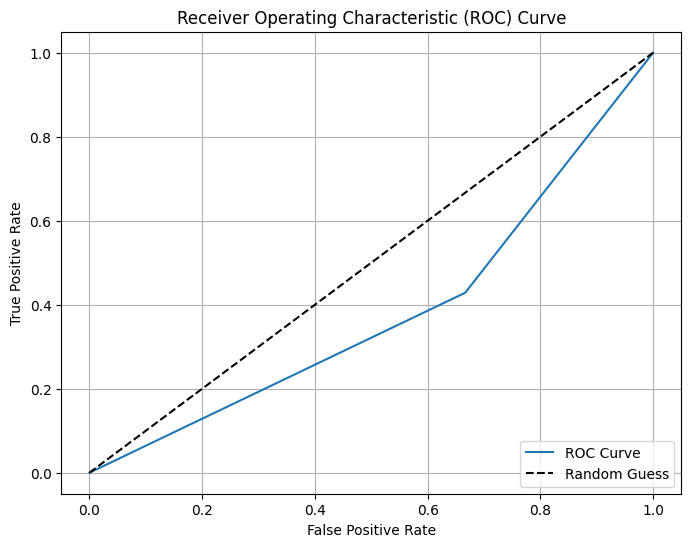

In [43]:
predictions_pa = ada_pipeline.predict_proba(X_test)

roc_calc = roc_curve(y_true = y_test, y_score = predictions_pa[:,1])
roc = pd.DataFrame(
    data = np.c_[roc_calc],
    columns = ('false positive rate', 'true positive rate', 'threshold')
)
print("AUC value:", roc_auc_score(y_true = y_test, y_score = predictions_pa[:,1]))

# Compute precision-recall curve
baseline_precision, baseline_recall, thresholds = precision_recall_curve(y_test, predictions_pa[:,1])

# Compute area under the curve (AUC)
baseline_auc_score = auc(baseline_recall, baseline_precision)

plot_roc_curve(roc)

              precision    recall  f1-score   support

           0       0.33      0.33      0.33        12
           1       0.43      0.43      0.43        14

    accuracy                           0.38        26
   macro avg       0.38      0.38      0.38        26
weighted avg       0.38      0.38      0.38        26



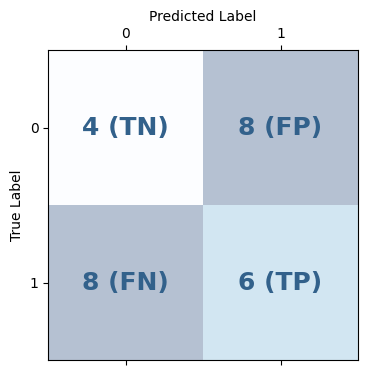

False Positive Rate (FPR): 0.667
Recall: 0.429
Negative Recall: 0.333
Precision: 0.429
F1 Score: 0.429


In [44]:
y_probs = ada_pipeline.predict_proba(X_test)[:, 1]
y_pred = ada_pipeline.predict(X_test)

# get the confusion matrix as a numpy array
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
# use the pretty function to make it nicer

LE = LabelEncoder()
y_train = LE.fit_transform(y_train)
y_test = LE.transform(y_test)
FP_i = [0,1]
TN_i = [0,0]
TP_i = [1,1]
FN_i = [1,0]

# Extracting the quantities from the confusion matrix 
FP = confmat[0,1]
TN = confmat[0,0]
TP = confmat[1,1]
FN = confmat[1,0]

#Calculation of FPR, Recall, Precision and F1 Score
# FPR
FPR = (FP)/(FP+TN)
# Recall
Recall = (TP)/(TP+FN)
# Negative recall
Negative_Recall = (TN)/(TN+FP)
# Precision
Precision = (TP)/(FP+TP)
# F1 Score
F1 = 2 * (Precision * Recall)/(Precision + Recall)

print(classification_report(y_test, y_pred))

pretty_confusion_matrix(confmat, LE.classes_, "",
                        labeling=True, highlight_indexes = [FP_i,FN_i,TP_i,TN_i])

print('False Positive Rate (FPR): '+ '%.3f' % FPR)
print('Recall: '+ '%.3f' % Recall)
print('Negative Recall: '+'%.3f' % Negative_Recall)

print('Precision: '+ '%.3f' % Precision)
print('F1 Score: '+ '%.3f' % F1)

### **Naive Bayes Classifiers**

##### **Bernoulli** --> maybe think of implementing tailored binarizing in feature engineering

In [ ]:
from sklearn.naive_bayes import BernoulliNB


# Define a custom importance getter for naive bayes
def nb_feature_importances(estimator):
    """
    For BernoulliNB (assumed binary classification), use the absolute difference between
    the feature_log_prob_ values for the two classes as a measure of feature importance.
    """
    if hasattr(estimator, "feature_log_prob_"):
        # For binary classification, feature_log_prob_ has shape (2, n_features)
        if estimator.feature_log_prob_.shape[0] == 2:
            return np.abs(estimator.feature_log_prob_[0] - estimator.feature_log_prob_[1])
        else:
            # For multi-class, you might consider another aggregation strategy.
            # For example, return the range (max - min) across classes for each feature.
            return np.ptp(estimator.feature_log_prob_, axis=0)
    else:
        raise AttributeError("The estimator does not have 'feature_log_prob_' attribute.")


def objective(params):

    n_features = int(params['n_features'])

    bern_params = {
        'alpha': params['alpha'],
        'binarize': params['binarize'],
        'fit_prior': params['fit_prior']
    
    }

    

    # Create an instance for RFE
    classifier_for_rfe = BernoulliNB(**bern_params)
    rfe = RFE(estimator=classifier_for_rfe, n_features_to_select=n_features, 
            importance_getter=nb_feature_importances)

    # Create a new instance for the final classifier
    classifier_final = BernoulliNB(**bern_params)
    pipeline = Pipeline(steps=[('rfe', rfe), ('clf', classifier_final)])

    # Use cross-validation to evaluate performance using negative recall
    score = cross_val_score(pipeline, X_train, y_train, scoring=negative_recall, cv=5).mean()
    
    # Hyperopt minimizes the objective, so return the negative score (to maximize negative recall)
    return {'loss': -score, 'status': STATUS_OK}

search_space = {
    'n_features' : hp.choice('n_features', [1,2,3,4,5,6]),   
    'alpha': hp.loguniform('alpha', -5, 1),  # alpha in range ~[0.006, 2.7]
    'binarize': hp.uniform('binarize', 0, 5),  # binarization threshold range
    'fit_prior': hp.choice('fit_prior', [True, False])  # Whether to learn prior


}

trials = Trials()
best = fmin(
    fn = objective,
    space = search_space,
    algo = tpe.suggest,
    max_evals=300,
    trials = trials
)

best_params = space_eval(search_space, best)
print("Best hyperparameters:", best_params)


  0%|          | 0/300 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 300/300 [02:33<00:00,  1.95trial/s, best loss: -0.6888888888888889]
Best hyperparameters: {'alpha': 0.26795385122827003, 'binarize': 4.753754297891551, 'fit_prior': False, 'n_features': 1}


In [55]:
bern_params = copy.deepcopy(best_params)
n_features = int(bern_params['n_features'])

del bern_params['n_features']

# Create an instance for RFE
classifier_for_rfe = BernoulliNB(**bern_params)
rfe = RFE(estimator=classifier_for_rfe, n_features_to_select=n_features, 
        importance_getter=nb_feature_importances)

# Create a new instance for the final classifier
classifier_final = BernoulliNB(**bern_params)
bern_pipeline = Pipeline(steps=[('rfe', rfe), ('clf', classifier_final)])

bern_pipeline.fit(X_train,y_train)
mask = bern_pipeline.named_steps['rfe'].support_
selected_feature_names_bern = X_train.columns[mask]

print("Selected features:", selected_feature_names_bern)

Selected features: Index(['X1'], dtype='object')


In [ ]:
# Extract the RandomForestClassifier from the pipeline
bern_model = bern_pipeline.named_steps["clf"]

# Check if the model has feature_importances_ attribute
if hasattr(bern_model, "feature_importances_"):
    # Get feature importances
    feature_importances = bern_model.feature_importances_

    # Create a DataFrame for feature importance ranking
    importance_df = pd.DataFrame({
        "Feature": selected_feature_names_rf,
        "Importance": feature_importances
    }).sort_values(by="Importance", ascending=False)

    # Print feature rankings
    print("Feature Importances:")
    print(importance_df)

    # Visualize feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
    plt.gca().invert_yaxis()
    plt.title("Feature Importances from Random Forest")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()
else:
    print("The model does not support feature importances.")


Negative Recall: 0.667
              precision    recall  f1-score   support

           0       0.57      0.67      0.62        12
           1       0.67      0.57      0.62        14

    accuracy                           0.62        26
   macro avg       0.62      0.62      0.62        26
weighted avg       0.62      0.62      0.62        26



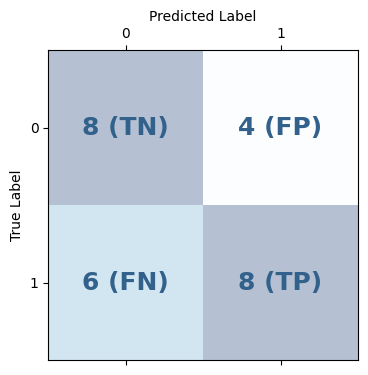

False Positive Rate (FPR): 0.333
Recall: 0.571
Negative Recall: 0.667
Precision: 0.667
F1 Score: 0.615


In [56]:
y_probs = bern_pipeline.predict_proba(X_test)[:, 1]
y_pred = bern_pipeline.predict(X_test)

# get the confusion matrix as a numpy array
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
# use the pretty function to make it nicer

LE = LabelEncoder()
y_train = LE.fit_transform(y_train)
y_test = LE.transform(y_test)
FP_i = [0,1]
TN_i = [0,0]
TP_i = [1,1]
FN_i = [1,0]

# Extracting the quantities from the confusion matrix 
FP = confmat[0,1]
TN = confmat[0,0]
TP = confmat[1,1]
FN = confmat[1,0]

#Calculation of FPR, Recall, Precision and F1 Score
# FPR
FPR = (FP)/(FP+TN)
# Recall
Recall = (TP)/(TP+FN)
Negative_Recall = (TN)/(TN+FP)
print('Negative Recall: '+'%.3f' % Negative_Recall)


# Precision
Precision = (TP)/(FP+TP)
# F1 Score
F1 = 2 * (Precision * Recall)/(Precision + Recall)

print(classification_report(y_test, y_pred))

pretty_confusion_matrix(confmat, LE.classes_, "",
                        labeling=True, highlight_indexes = [FP_i,FN_i,TP_i,TN_i])

print('False Positive Rate (FPR): '+ '%.3f' % FPR)
print('Recall: '+ '%.3f' % Recall)
print('Negative Recall: '+'%.3f' % Negative_Recall)

print('Precision: '+ '%.3f' % Precision)
print('F1 Score: '+ '%.3f' % F1)

AUC value: 0.6190476190476191


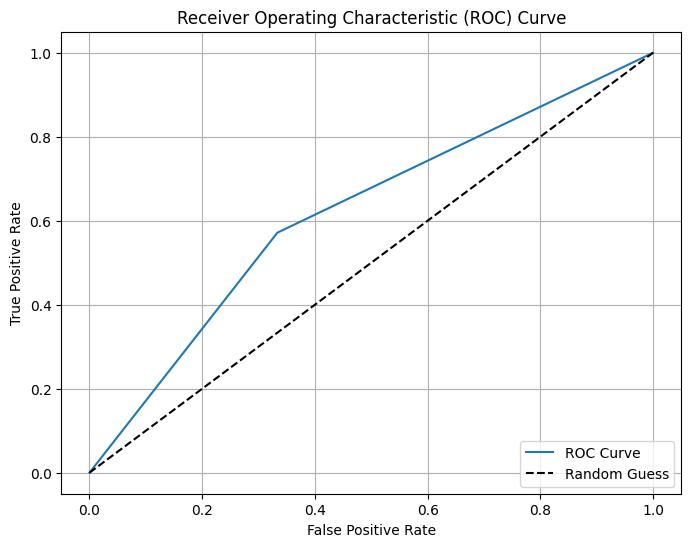

In [57]:
predictions_pa = bern_pipeline.predict_proba(X_test)

roc_calc = roc_curve(y_true = y_test, y_score = predictions_pa[:,1])
roc = pd.DataFrame(
    data = np.c_[roc_calc],
    columns = ('false positive rate', 'true positive rate', 'threshold')
)
print("AUC value:", roc_auc_score(y_true = y_test, y_score = predictions_pa[:,1]))

# Compute precision-recall curve
baseline_precision, baseline_recall, thresholds = precision_recall_curve(y_test, predictions_pa[:,1])

# Compute area under the curve (AUC)
baseline_auc_score = auc(baseline_recall, baseline_precision)

plot_roc_curve(roc)

##### **MultinomialNB**

In [58]:
from sklearn.naive_bayes import MultinomialNB




def objective(params):

    n_features = int(params['n_features'])

    bern_params = {
        'alpha': params['alpha'],
        'fit_prior': params['fit_prior']
    
    }

    # Create an instance for RFE
    classifier_for_rfe = MultinomialNB(**bern_params)
    rfe = RFE(estimator=classifier_for_rfe, n_features_to_select=n_features, 
            importance_getter=nb_feature_importances)

    # Create a new instance for the final classifier
    classifier_final = MultinomialNB(**bern_params)
    pipeline = Pipeline(steps=[('rfe', rfe), ('clf', classifier_final)])

    # Use cross-validation to evaluate performance using negative recall
    score = cross_val_score(pipeline, X_train, y_train, scoring=negative_recall, cv=5).mean()
    
    # Hyperopt minimizes the objective, so return the negative score (to maximize negative recall)
    return {'loss': -score, 'status': STATUS_OK}

search_space = {
    'n_features' : hp.choice('n_features', [1,2,3,4,5,6]),   
    'alpha': hp.loguniform('alpha', -5, 1),  # alpha in range ~[0.006, 2.7]
    'fit_prior': hp.choice('fit_prior', [True, False])  # Whether to learn prior

}

trials = Trials()
best = fmin(
    fn = objective,
    space = search_space,
    algo = tpe.suggest,
    max_evals=300,
    trials = trials
)

best_params = space_eval(search_space, best)
print("Best hyperparameters:", best_params)

100%|██████████| 300/300 [01:18<00:00,  3.84trial/s, best loss: -1.0]              
Best hyperparameters: {'alpha': 0.21986846744489222, 'fit_prior': False, 'n_features': 1}


In [59]:
mult_params = copy.deepcopy(best_params)
n_features = int(mult_params['n_features'])

del mult_params['n_features']

# Create an instance for RFE
classifier_for_rfe = MultinomialNB(**mult_params)
rfe = RFE(estimator=classifier_for_rfe, n_features_to_select=n_features, 
        importance_getter=nb_feature_importances)

# Create a new instance for the final classifier
classifier_final = MultinomialNB(**mult_params)
mult_pipeline = Pipeline(steps=[('rfe', rfe), ('clf', classifier_final)])

mult_pipeline.fit(X_train,y_train)
mask = mult_pipeline.named_steps['rfe'].support_
selected_feature_names_mult = X_train.columns[mask]

print("Selected features:", selected_feature_names_mult)

Selected features: Index(['X5'], dtype='object')


In [ ]:
# Extract the RandomForestClassifier from the pipeline
mult_model = mult_pipeline.named_steps["clf"]

# Check if the model has feature_importances_ attribute
if hasattr(mult_model, "feature_importances_"):
    # Get feature importances
    feature_importances = mult_model.feature_importances_

    # Create a DataFrame for feature importance ranking
    importance_df = pd.DataFrame({
        "Feature": selected_feature_names_rf,
        "Importance": feature_importances
    }).sort_values(by="Importance", ascending=False)

    # Print feature rankings
    print("Feature Importances:")
    print(importance_df)

    # Visualize feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
    plt.gca().invert_yaxis()
    plt.title("Feature Importances from Random Forest")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()
else:
    print("The model does not support feature importances.")

Negative Recall: 1.000
              precision    recall  f1-score   support

           0       0.46      1.00      0.63        12
           1       0.00      0.00      0.00        14

    accuracy                           0.46        26
   macro avg       0.23      0.50      0.32        26
weighted avg       0.21      0.46      0.29        26



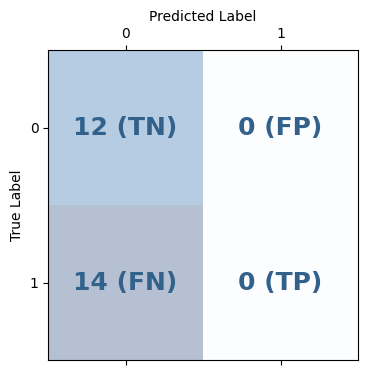

False Positive Rate (FPR): 0.000
Recall: 0.000
Negative Recall: 1.000
Precision: nan
F1 Score: nan


In [61]:
y_probs = mult_pipeline.predict_proba(X_test)[:, 1]
y_pred = mult_pipeline.predict(X_test)

# get the confusion matrix as a numpy array
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
# use the pretty function to make it nicer

LE = LabelEncoder()
y_train = LE.fit_transform(y_train)
y_test = LE.transform(y_test)
FP_i = [0,1]
TN_i = [0,0]
TP_i = [1,1]
FN_i = [1,0]

# Extracting the quantities from the confusion matrix 
FP = confmat[0,1]
TN = confmat[0,0]
TP = confmat[1,1]
FN = confmat[1,0]

#Calculation of FPR, Recall, Precision and F1 Score
# FPR
FPR = (FP)/(FP+TN)
# Recall
Recall = (TP)/(TP+FN)
Negative_Recall = (TN)/(TN+FP)
print('Negative Recall: '+'%.3f' % Negative_Recall)


# Precision
Precision = (TP)/(FP+TP)
# F1 Score
F1 = 2 * (Precision * Recall)/(Precision + Recall)

print(classification_report(y_test, y_pred))

pretty_confusion_matrix(confmat, LE.classes_, "",
                        labeling=True, highlight_indexes = [FP_i,FN_i,TP_i,TN_i])

print('False Positive Rate (FPR): '+ '%.3f' % FPR)
print('Recall: '+ '%.3f' % Recall)
print('Negative Recall: '+'%.3f' % Negative_Recall)

print('Precision: '+ '%.3f' % Precision)
print('F1 Score: '+ '%.3f' % F1)

AUC value: 0.5


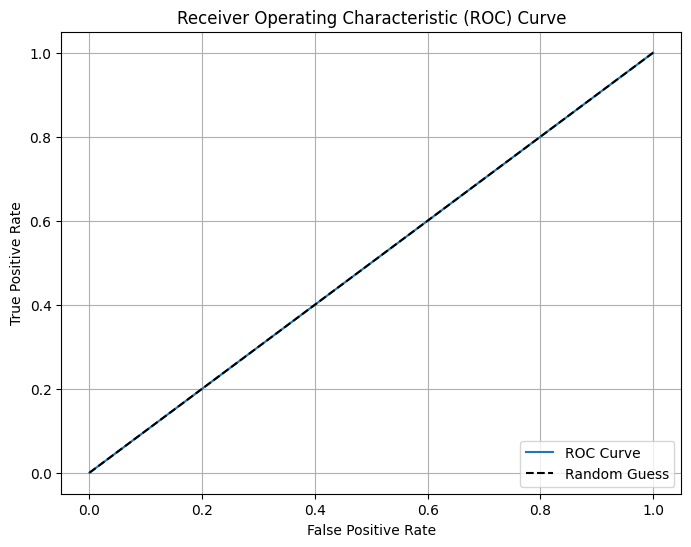

In [62]:
predictions_pa = mult_pipeline.predict_proba(X_test)

roc_calc = roc_curve(y_true = y_test, y_score = predictions_pa[:,1])
roc = pd.DataFrame(
    data = np.c_[roc_calc],
    columns = ('false positive rate', 'true positive rate', 'threshold')
)
print("AUC value:", roc_auc_score(y_true = y_test, y_score = predictions_pa[:,1]))

# Compute precision-recall curve
baseline_precision, baseline_recall, thresholds = precision_recall_curve(y_test, predictions_pa[:,1])

# Compute area under the curve (AUC)
baseline_auc_score = auc(baseline_recall, baseline_precision)

plot_roc_curve(roc)

### **Logistic Regression**

In [91]:

from sklearn.linear_model import LogisticRegression


def objective(params):

    n_features = int(params['n_features'])

    log_params = {
        'C': params['C'],
        'class_weight': params['class_weight'],
        'penalty': params['penalty'],
        'random_state': params['random_state'],
        'solver' : params['solver']
    
    }

    if params['penalty'] == 'elasticnet':
        log_params['l1_ratio'] = params['l1_ratio']
    else:
        log_params['l1_ratio'] = None


    # Create an instance for RFE
    classifier_for_rfe = LogisticRegression(**log_params)
    rfe = RFE(estimator=classifier_for_rfe, 
              n_features_to_select=n_features)

    # Create a new instance for the final classifier
    classifier_final = LogisticRegression(**log_params)
    pipeline = Pipeline(steps=[('rfe', rfe), ('clf', classifier_final)])

    # Use cross-validation to evaluate performance using negative recall
    score = cross_val_score(pipeline, X_train, y_train, scoring=negative_recall, cv=5).mean()
    
    # Hyperopt minimizes the objective, so return the negative score (to maximize negative recall)
    return {'loss': -score, 'status': STATUS_OK}




search_space = {
    'n_features' : hp.choice('n_features', [1,2,3,4,5,6]), 
    'C': hp.loguniform('C', -5, 25),  
    'class_weight': hp.choice('class_weight', [None, "balanced"]),
    'penalty' : hp.choice('penalty', ['l1', 'l2','elasticnet', None]),
    'l1_ratio': hp.uniform('l1_ratio', 0, 1),
    'random_state' : hp.choice('random_state', [int(seed)]),
    'solver' : hp.choice('solver', ['saga'])
}

trials = Trials()
best = fmin(
    fn = objective,
    space = search_space,
    algo = tpe.suggest,
    max_evals=300,
    trials = trials
)

best_params = space_eval(search_space, best)
print("Best hyperparameters:", best_params)


100%|██████████| 300/300 [00:54<00:00,  5.48trial/s, best loss: -1.0]              
Best hyperparameters: {'C': 0.03368041107553865, 'class_weight': 'balanced', 'l1_ratio': 0.16047477503536106, 'n_features': 2, 'penalty': 'l1', 'random_state': 7980, 'solver': 'saga'}


In [92]:
log_params = copy.deepcopy(best_params)
n_features = int(log_params['n_features'])

del log_params['n_features']

# Create an instance for RFE
classifier_for_rfe = LogisticRegression(**log_params)

rfe = RFE(estimator=classifier_for_rfe, 
              n_features_to_select=n_features)

# Create a new instance for the final classifier
classifier_final = LogisticRegression(**log_params)
log_pipeline = Pipeline(steps=[('rfe', rfe), ('clf', classifier_final)])


log_pipeline.fit(X_train,y_train)
mask = log_pipeline.named_steps['rfe'].support_
selected_feature_names_log = X_train.columns[mask]

print("Selected features:", selected_feature_names_log)

Selected features: Index(['X5', 'X6'], dtype='object')


Coefficients of the best logistic regression model:
[0. 0.]
Intercept of the best logistic regression model:
0.0


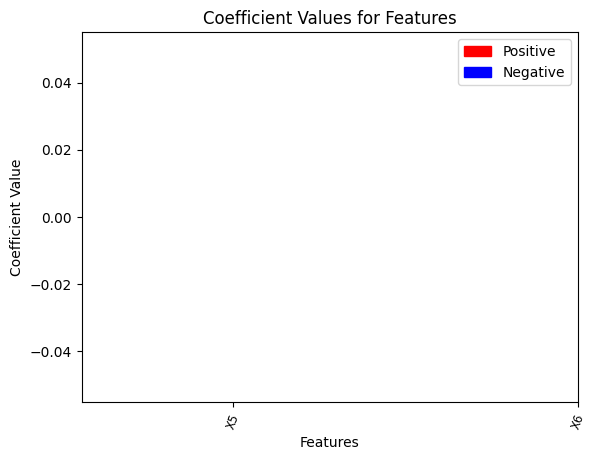

In [93]:
coefficients = log_pipeline.named_steps['clf'].coef_[0]
print("Coefficients of the best logistic regression model:")
print(coefficients)
print('Intercept of the best logistic regression model:')
print(coefficients[0])

plot_coefs(coefficients[1:], selected_feature_names_log, 'Coefficient Values for Features')


Negative Recall: 1.000
              precision    recall  f1-score   support

           0       0.46      1.00      0.63        12
           1       0.00      0.00      0.00        14

    accuracy                           0.46        26
   macro avg       0.23      0.50      0.32        26
weighted avg       0.21      0.46      0.29        26



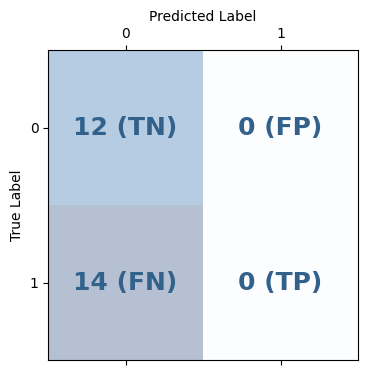

False Positive Rate (FPR): 0.000
Recall: 0.000
Negative Recall: 1.000
Precision: nan
F1 Score: nan


In [94]:
y_probs = log_pipeline.predict_proba(X_test)[:, 1]
y_pred = log_pipeline.predict(X_test)

# get the confusion matrix as a numpy array
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
# use the pretty function to make it nicer

LE = LabelEncoder()
y_train = LE.fit_transform(y_train)
y_test = LE.transform(y_test)
FP_i = [0,1]
TN_i = [0,0]
TP_i = [1,1]
FN_i = [1,0]

# Extracting the quantities from the confusion matrix 
FP = confmat[0,1]
TN = confmat[0,0]
TP = confmat[1,1]
FN = confmat[1,0]

#Calculation of FPR, Recall, Precision and F1 Score
# FPR
FPR = (FP)/(FP+TN)
# Recall
Recall = (TP)/(TP+FN)
Negative_Recall = (TN)/(TN+FP)
print('Negative Recall: '+'%.3f' % Negative_Recall)


# Precision
Precision = (TP)/(FP+TP)
# F1 Score
F1 = 2 * (Precision * Recall)/(Precision + Recall)

print(classification_report(y_test, y_pred))

pretty_confusion_matrix(confmat, LE.classes_, "",
                        labeling=True, highlight_indexes = [FP_i,FN_i,TP_i,TN_i])

print('False Positive Rate (FPR): '+ '%.3f' % FPR)
print('Recall: '+ '%.3f' % Recall)
print('Negative Recall: '+'%.3f' % Negative_Recall)

print('Precision: '+ '%.3f' % Precision)
print('F1 Score: '+ '%.3f' % F1)

AUC value: 0.5


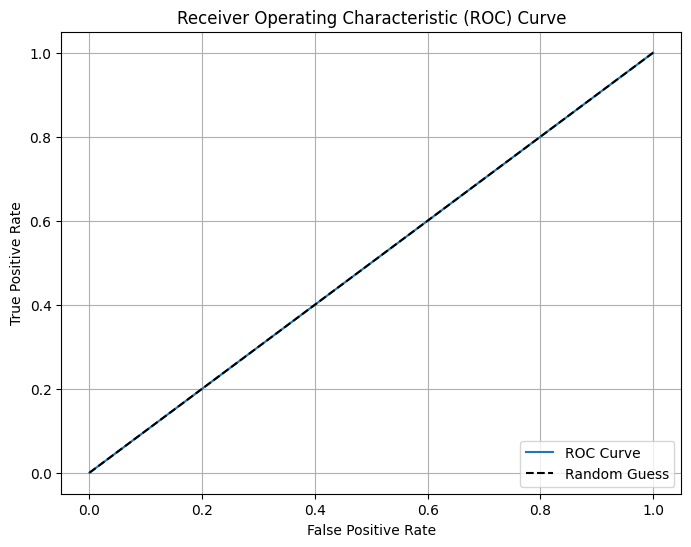

In [95]:
predictions_pa = log_pipeline.predict_proba(X_test)

roc_calc = roc_curve(y_true = y_test, y_score = predictions_pa[:,1])
roc = pd.DataFrame(
    data = np.c_[roc_calc],
    columns = ('false positive rate', 'true positive rate', 'threshold')
)
print("AUC value:", roc_auc_score(y_true = y_test, y_score = predictions_pa[:,1]))

# Compute precision-recall curve
baseline_precision, baseline_recall, thresholds = precision_recall_curve(y_test, predictions_pa[:,1])

# Compute area under the curve (AUC)
baseline_auc_score = auc(baseline_recall, baseline_precision)

plot_roc_curve(roc)